# What Makes a Champion?
## DSCI 100 Group 15 Project Proposal

Arimoto, Yuhei - Student Number | 
Dufour-Nogueira, Emma Héloïse - 34570614 | 
Huang, Felix - Student Number | 
Tan Palanca, Katrina Marie (Kim) - 98857568

### Introduction

Drawing predictions based on existing data sets provides a detailed interpretation and conclusions regarding the observations within it. Regression is one way in which predictive analysis of a data set can be achieved, predicting a numerical observation. Using the data set “Game results for Top 500 Players from 2017-2019”, specifically "atp2017-2019.csv", created by Jeff Sackman is the primary data to be manipulated.

The goal of this project is to create a K-nearest neighbors (KNN) regression model that will determine the probability that a player will win a tennis game based on their skills in serving through the following predictive question:
- How likely could a professional tennis player be to win a tennis game based on their serving skill?

### Preliminary Exploratory Data Analysis

In [57]:
library(tidyverse)
library(repr)
library(tidymodels)

set.seed(1234)

#this library() function loads the tidymodels, repr, and tidyverse libraries into R
#the set.seed() function sets the seed for the project

In [56]:
data <- read_csv("atp2017-2019.csv")
#the tennnis player data is referred to as the object "data" throughout this analysis

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



In [35]:
data <- data%>%
    select(winner_name, minutes, w_ace, w_df, w_svpt, w_SvGms, w_1stIn, w_1stWon)%>%
#the columns relevant to our analysis are selected using this select() function
    filter(!is.na(winner_name), !is.na(minutes), !is.na(w_ace), !is.na(w_df), !is.na(w_svpt),
          !is.na(w_SvGms), !is.na(w_1stIn), !is.na(w_1stWon))
#the !is.na() argument in the filter() function eliminates NA values in the relevant columns

head(data, 5)

winner_name,minutes,w_ace,w_df,w_svpt,w_SvGms,w_1stIn,w_1stWon
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Kei Nishikori,124,3,3,77,13,44,31
Daniil Medvedev,82,10,1,52,10,33,28
Kei Nishikori,66,2,2,47,8,33,26
Jo Wilfried Tsonga,106,12,2,68,11,43,34
Daniil Medvedev,129,12,3,105,16,68,48


In [36]:
data <- data%>%
    group_by(winner_name)%>%
    summarize(
        number_of_wins = n(), 
        avg_duration = mean(minutes), 
        avg_ace = mean(w_ace), 
        avg_df = mean(w_df), 
        avg_svpt = mean(w_svpt), 
        avg_svgm = mean(w_SvGms), 
        avg_first = mean(w_1stIn),
        avg_first_won = mean(w_1stWon))%>%
#removing repeats by average all the values over three years
    mutate(
        total_avg_svpt = avg_svpt + avg_svgm, 
        first_win_percentage_avg = (avg_first_won/avg_first)*100)%>%
#summing service points and service games (both are points earned by serving)
    select(
        winner_name, 
        number_of_wins, 
        avg_duration, 
        avg_ace, 
        avg_df, 
        total_avg_svpt, 
        first_win_percentage_avg)%>%
#selecting relevant variables
    mutate(
        number_of_wins = as.double(number_of_wins), 
        avg_duration = round(avg_duration, 2), 
        avg_ace = round(avg_ace, 2), 
        avg_df = round(avg_df, 2), 
        total_avg_svpt = round(total_avg_svpt, 2), 
        first_win_percentage_avg = round(first_win_percentage_avg, 2))
#converting variables to appropriate data types and rounding to 2 decimal places

head(data, 5)

`summarise()` ungrouping output (override with `.groups` argument)



winner_name,number_of_wins,avg_duration,avg_ace,avg_df,total_avg_svpt,first_win_percentage_avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Adam Pavlasek,3,124.67,11.33,3.67,118.67,76.28
Adrian Mannarino,80,111.79,6.09,2.24,92.75,73.38
Adrian Menendez Maceiras,4,120.00,7.25,2.50,99.00,71.95
Akira Santillan,2,44.50,4.00,1.50,50.50,84.62
Albert Ramos,72,125.51,3.97,2.32,96.43,71.86


In [37]:
data_split <- initial_split(data, prop = 0.75, strata = number_of_wins)
data_train <- training(data_split)
data_test <- testing(data_split)
#randomly splits 75% of the data into the training and testing sets using
#number_of_wins as the strata

In [55]:
train_summary <- data_train%>%
    tibble(number_of_players = nrow(data_train),                             #total number of players in the training dataset
            avg_match_duration = mean(avg_duration),                         #average duration of the winning players' matches
            avg_ace_n = mean(avg_ace),                                       #average number of aces among the winning players
            avg_df_n = mean(avg_df),                                         #average number of double faults among the winning players
            avg_total_avg_svpt = mean(total_avg_svpt),                       #average number of total points earned through serving among the winning players
            avg_first_win_percentage_avg = mean(first_win_percentage_avg),   #average percentage of succesful first serves (i.e. point-earning) among the winning players
            top_win_n = max(number_of_wins),                                 #highest number of wins in the training dataset
            bottom_win_n = min(number_of_wins))%>%                           #lowest number of wins in the training dataset
    select(number_of_players, avg_match_duration, avg_ace_n, avg_df_n,
            avg_total_avg_svpt, avg_first_win_percentage_avg, top_win_n, bottom_win_n)%>%
    slice(1)%>%
    mutate(number_of_players = as.double(number_of_players),
            avg_match_duration = round(avg_match_duration, 2),
            avg_ace_n = round(avg_ace_n, 2), avg_df_n = round(avg_df_n, 2),
            avg_total_avg_svpt = round(avg_total_avg_svpt, 2),
            avg_first_win_percentage_avg = round(avg_first_win_percentage_avg, 2))
train_summary

number_of_players,avg_match_duration,avg_ace_n,avg_df_n,avg_total_avg_svpt,avg_first_win_percentage_avg,top_win_n,bottom_win_n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
191,112.04,6.94,2.88,95.32,75.39,150,1


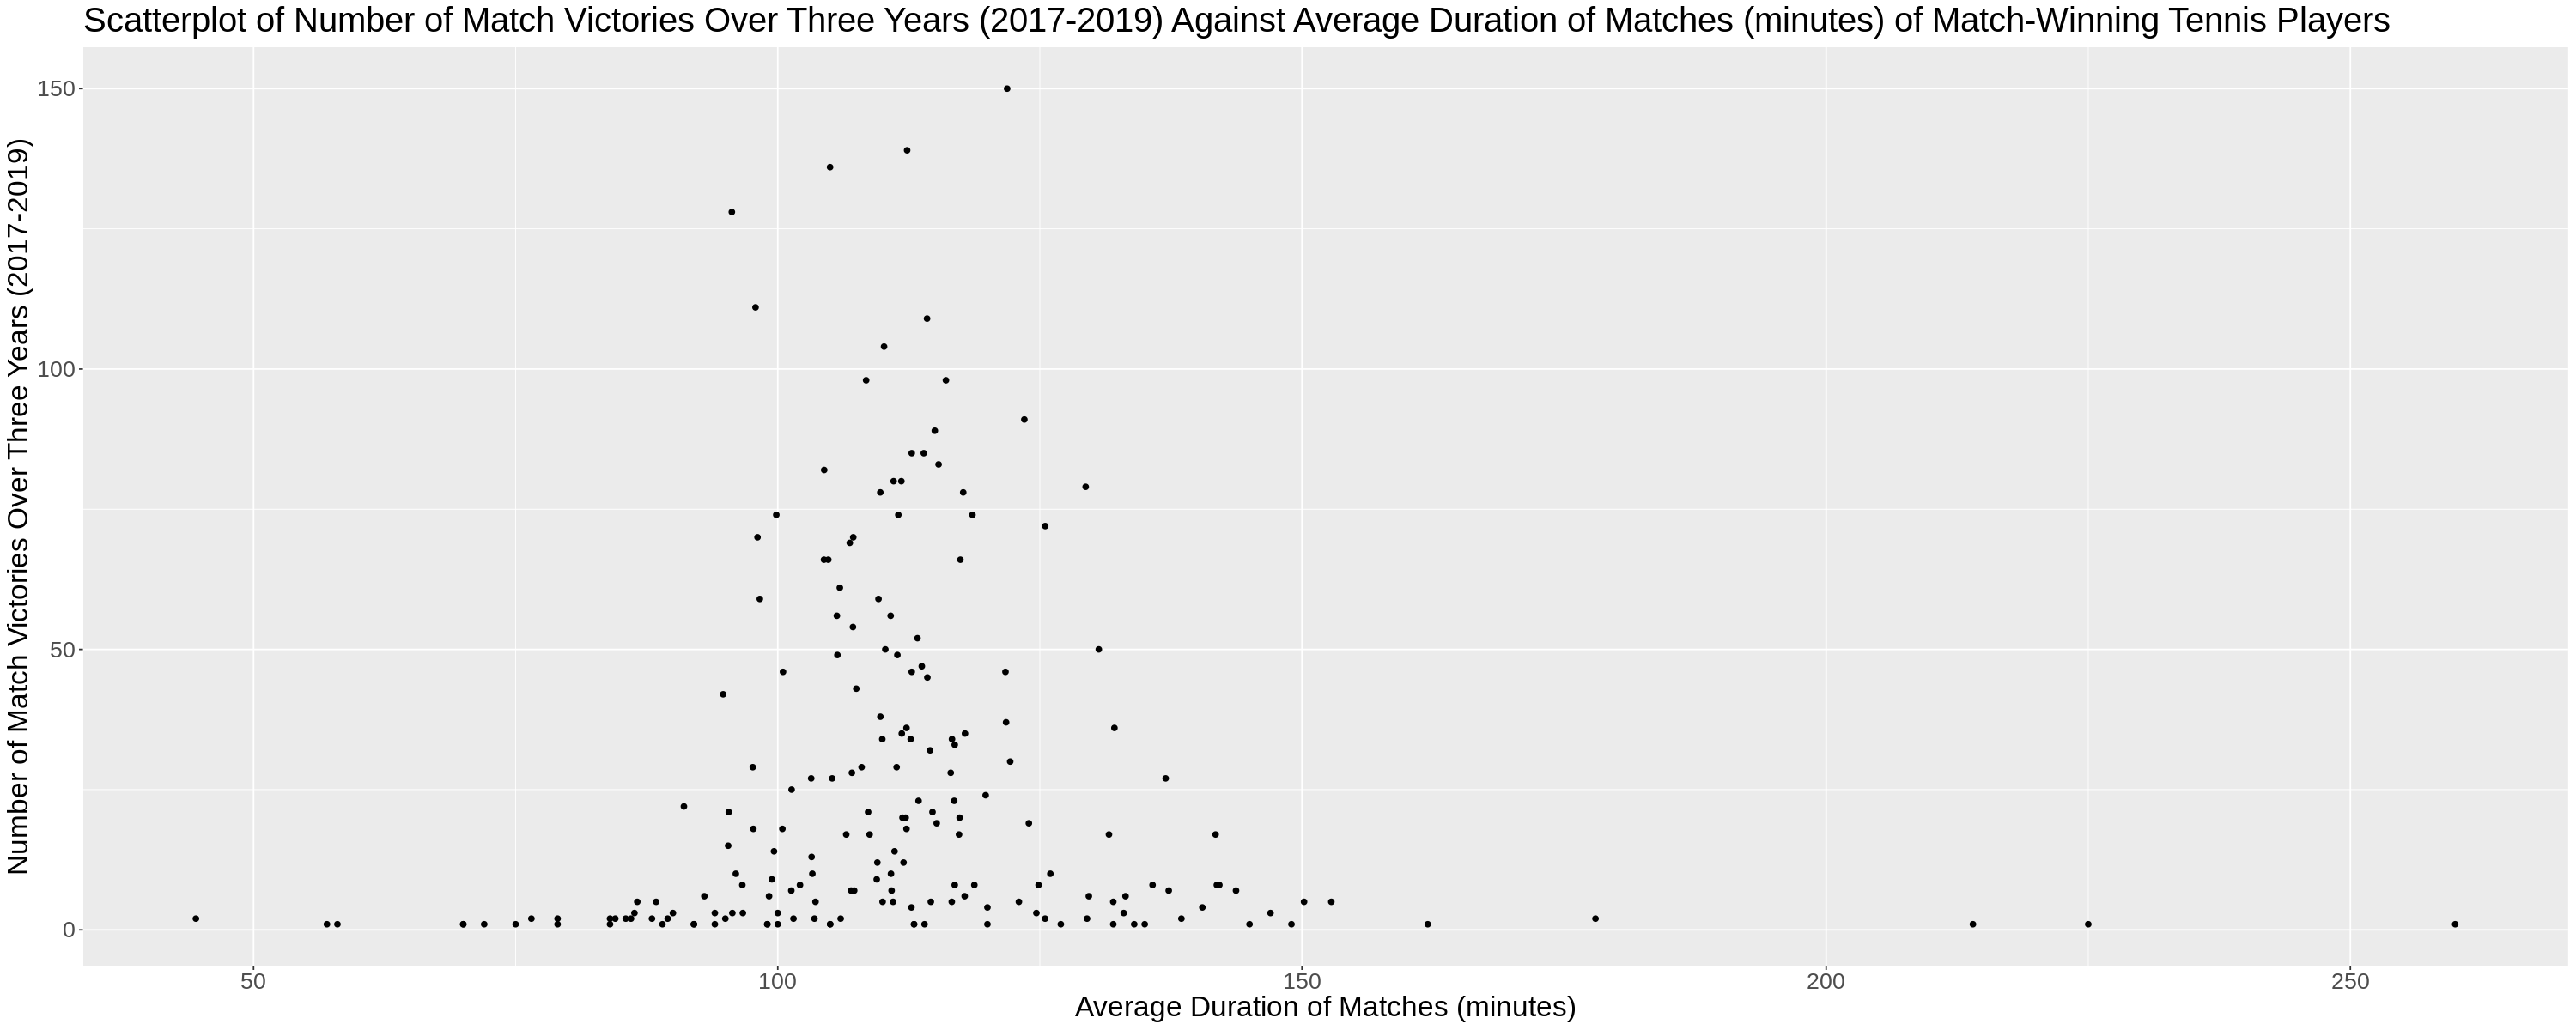

In [45]:
options(repr.plot.width = 25, repr.plot.height = 10)

duration_scatterplot <- data_train%>%
    ggplot(aes(x=avg_duration, y=number_of_wins))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Duration of Matches (minutes)",
         y="Number of Match Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Number of Match Victories Over Three Years (2017-2019) Against Average Duration of Matches (minutes) of Match-Winning Tennis Players")
duration_scatterplot

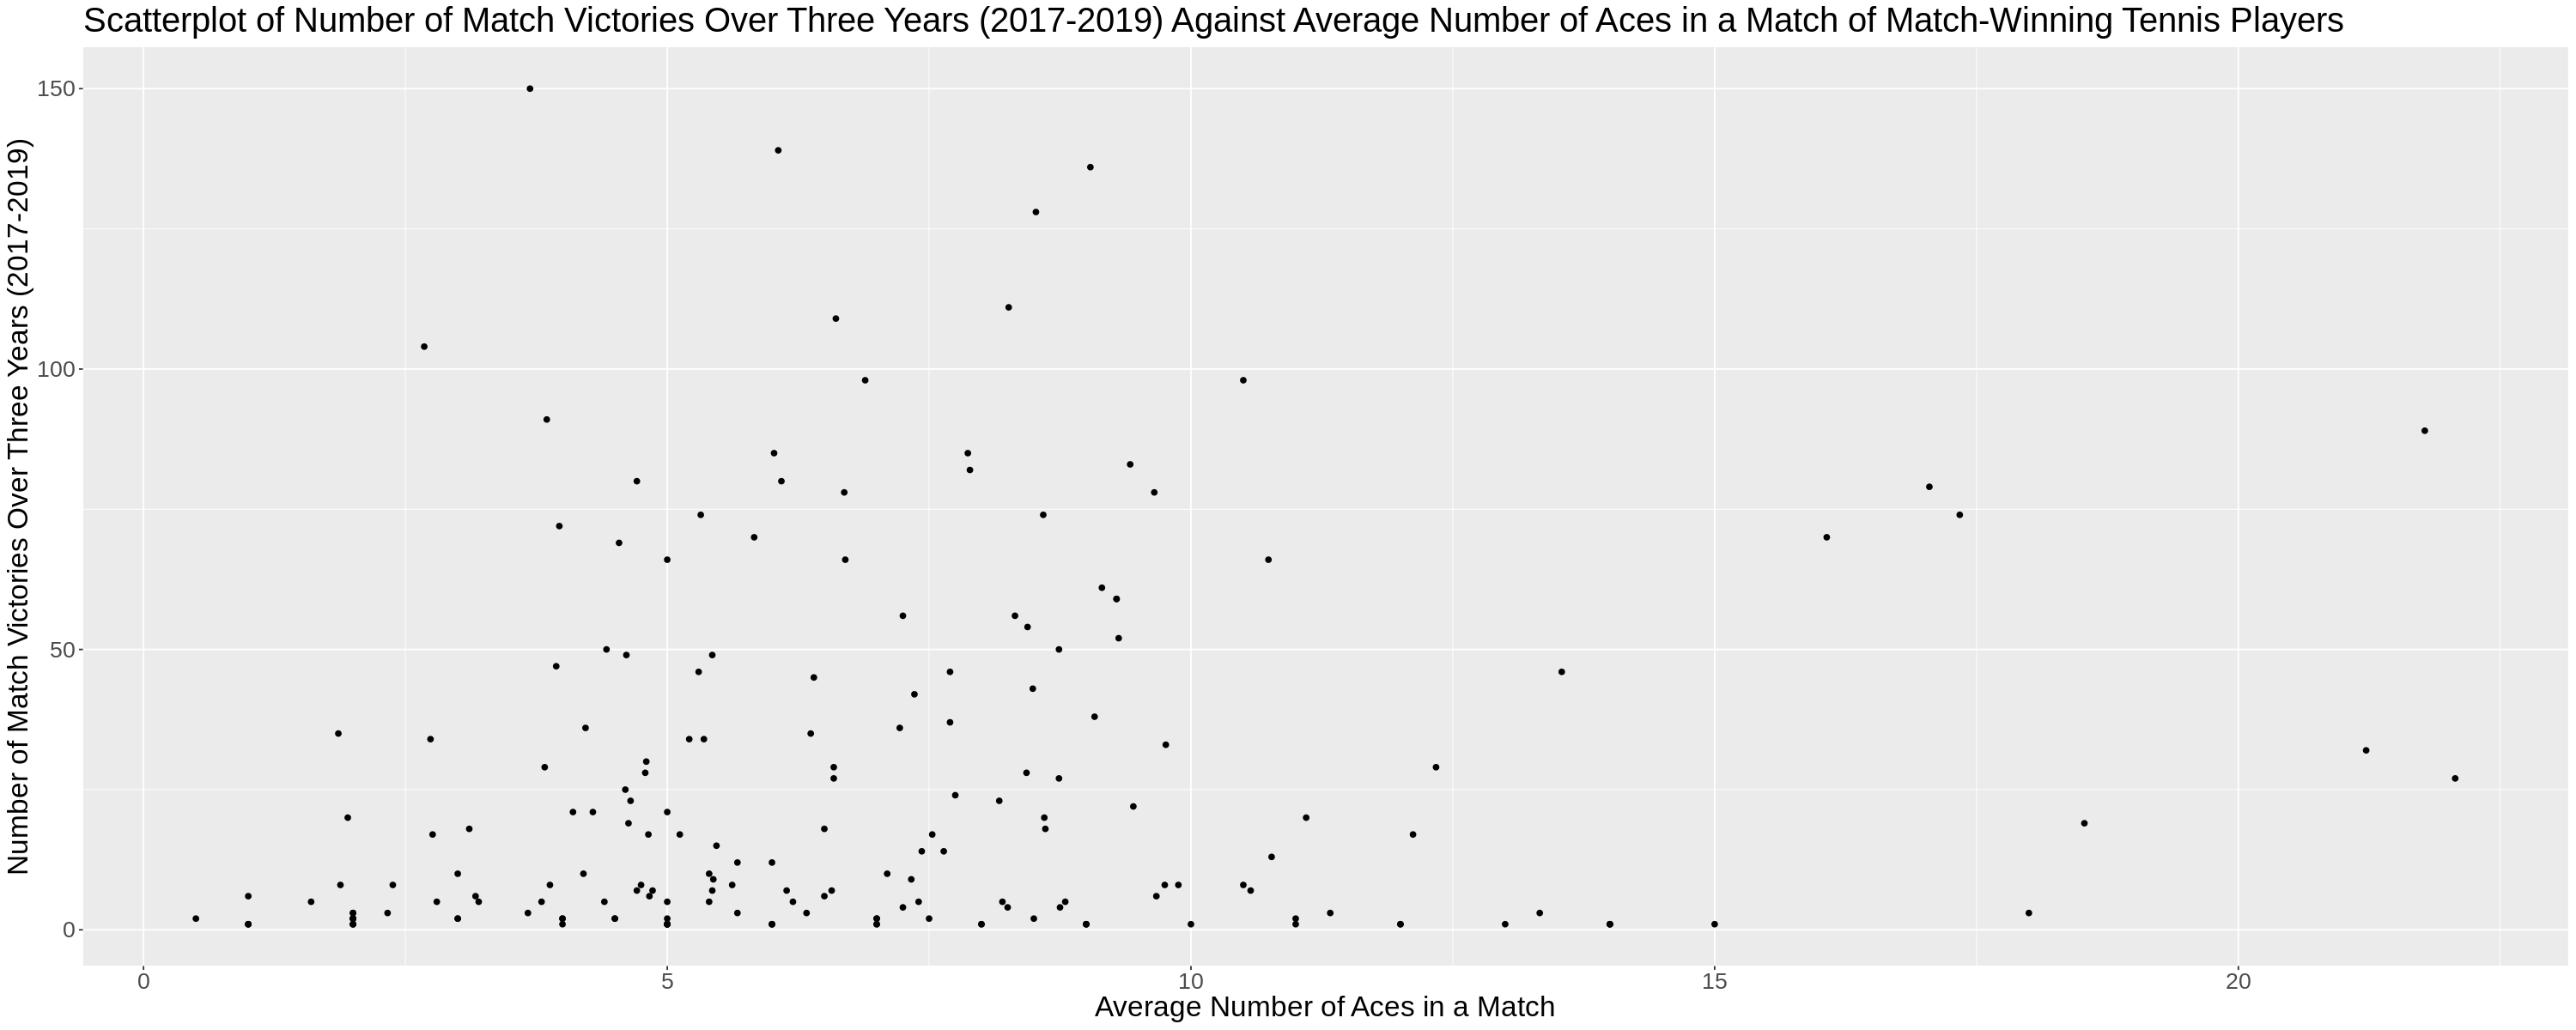

In [46]:
options(repr.plot.width = 25, repr.plot.height = 10)

ace_scatterplot <- data_train%>%
    ggplot(aes(x=avg_ace, y=number_of_wins))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Aces in a Match",
         y="Number of Match Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Number of Match Victories Over Three Years (2017-2019) Against Average Number of Aces in a Match of Match-Winning Tennis Players")
ace_scatterplot

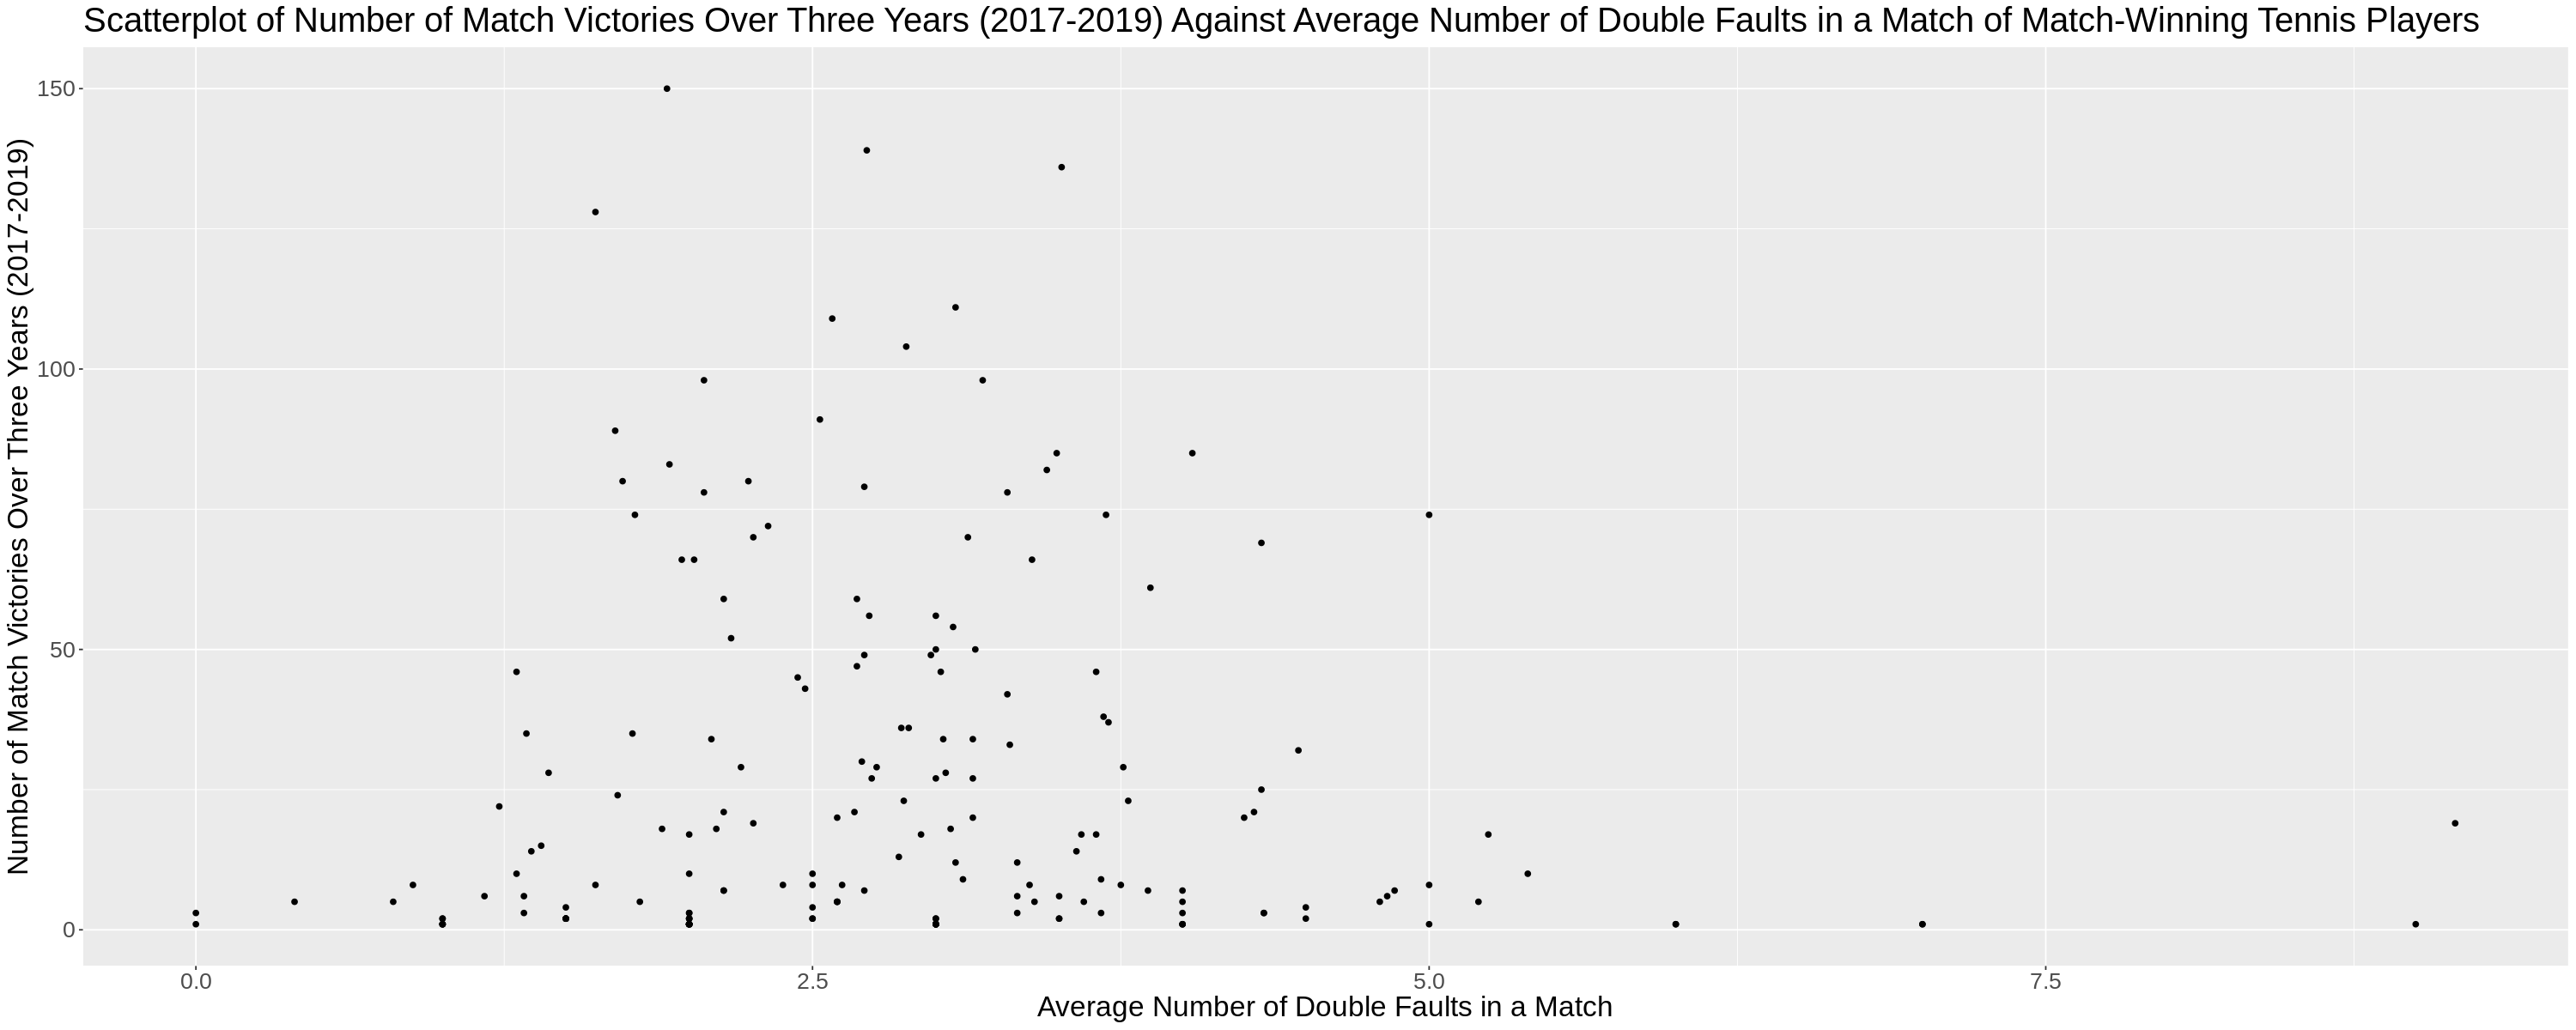

In [47]:
options(repr.plot.width = 25, repr.plot.height = 10)

df_scatterplot <- data_train%>%
    ggplot(aes(x=avg_df, y=number_of_wins))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Double Faults in a Match",
         y="Number of Match Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Number of Match Victories Over Three Years (2017-2019) Against Average Number of Double Faults in a Match of Match-Winning Tennis Players")
df_scatterplot

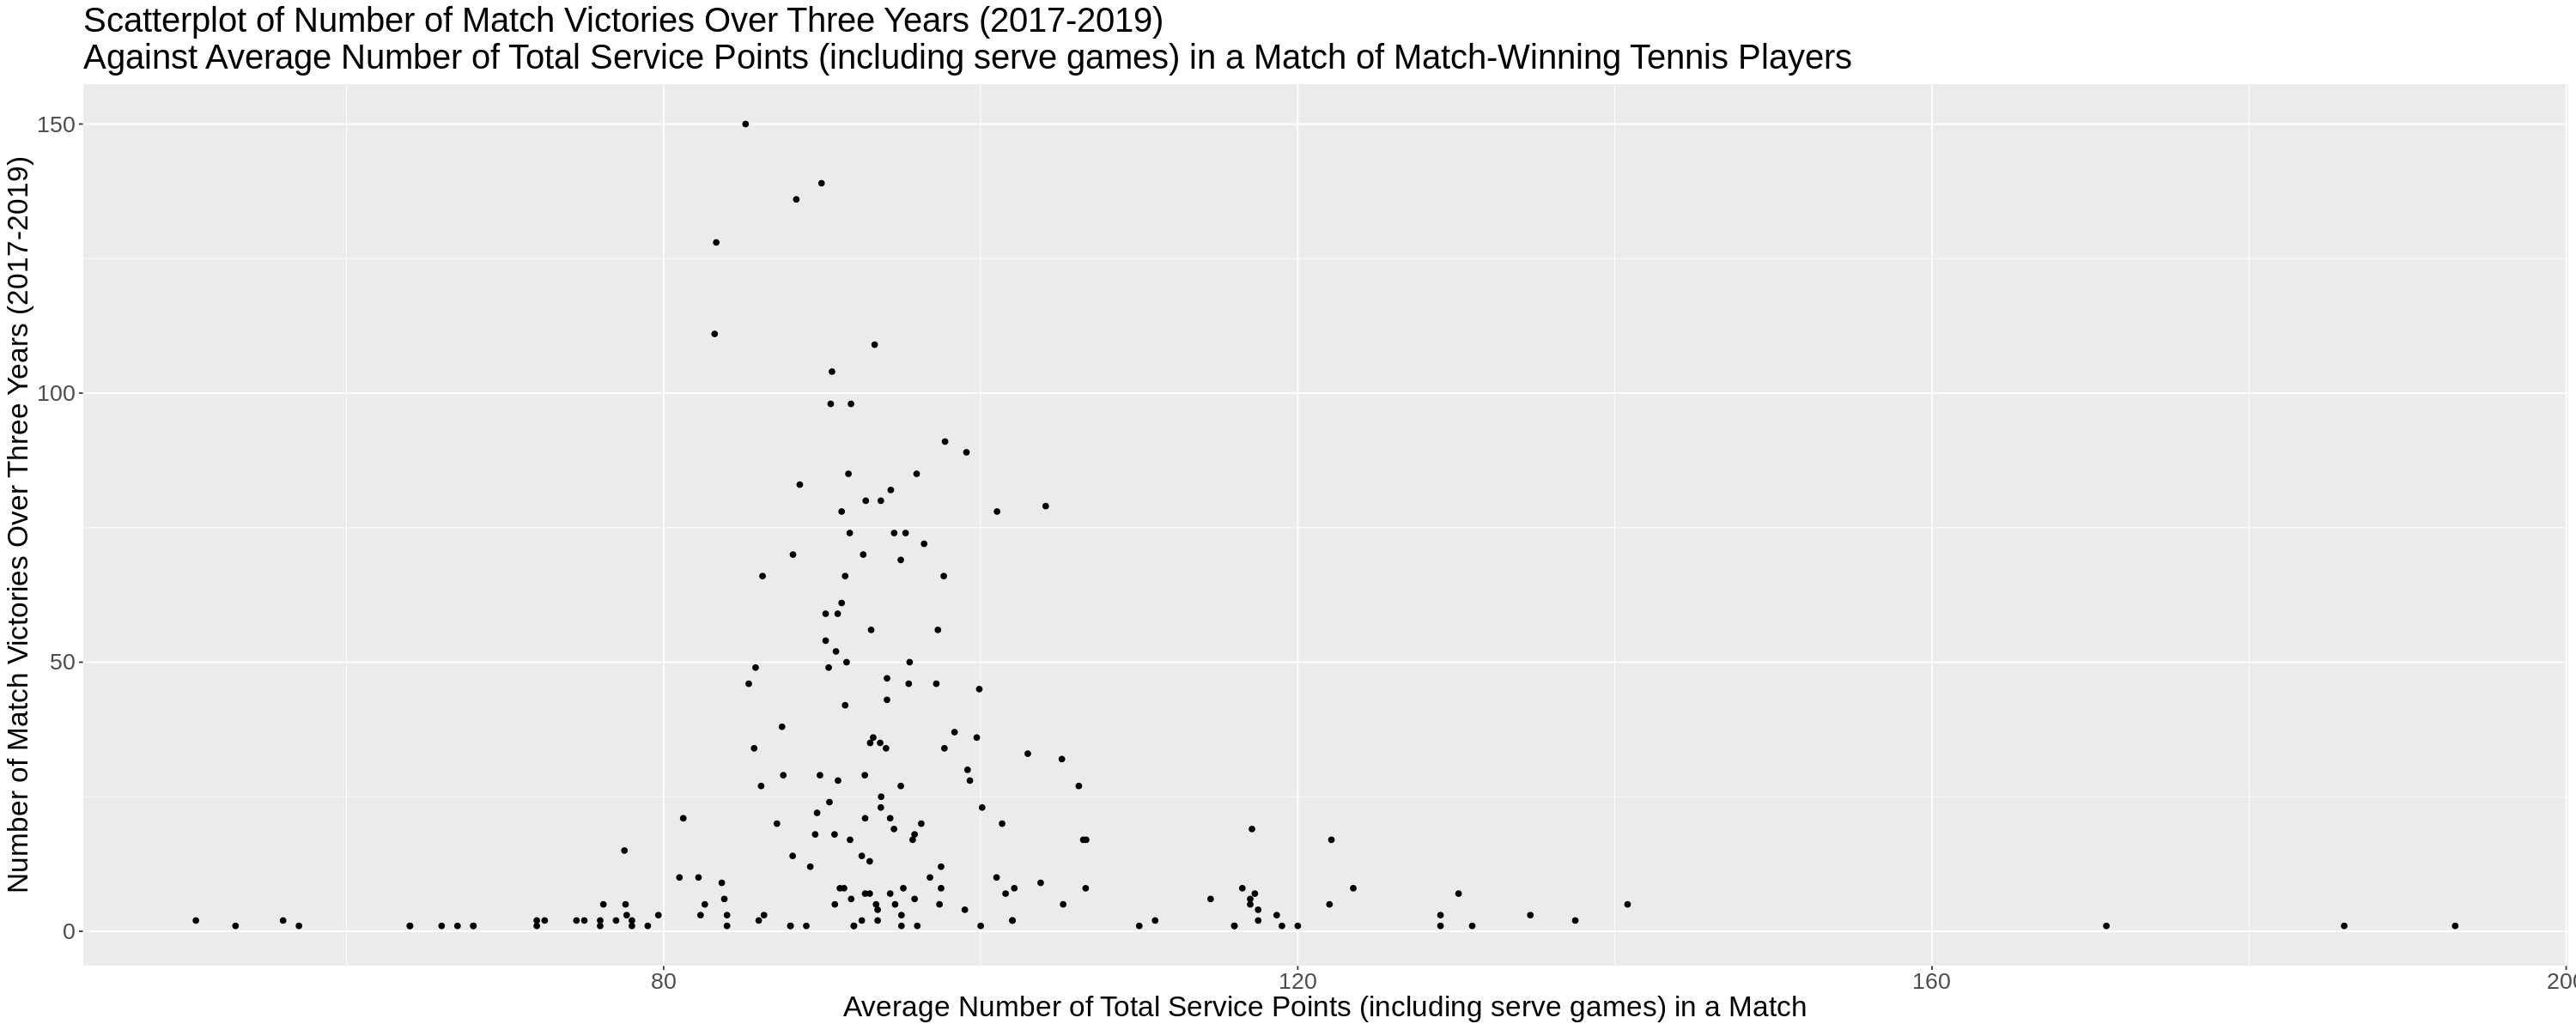

In [52]:
options(repr.plot.width = 25, repr.plot.height = 10)

svpt_scatterplot <- data_train%>%
    ggplot(aes(x=total_avg_svpt, y=number_of_wins))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Number of Total Service Points (including serve games) in a Match",
         y="Number of Match Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Number of Match Victories Over Three Years (2017-2019) \nAgainst Average Number of Total Service Points (including serve games) in a Match of Match-Winning Tennis Players")
svpt_scatterplot

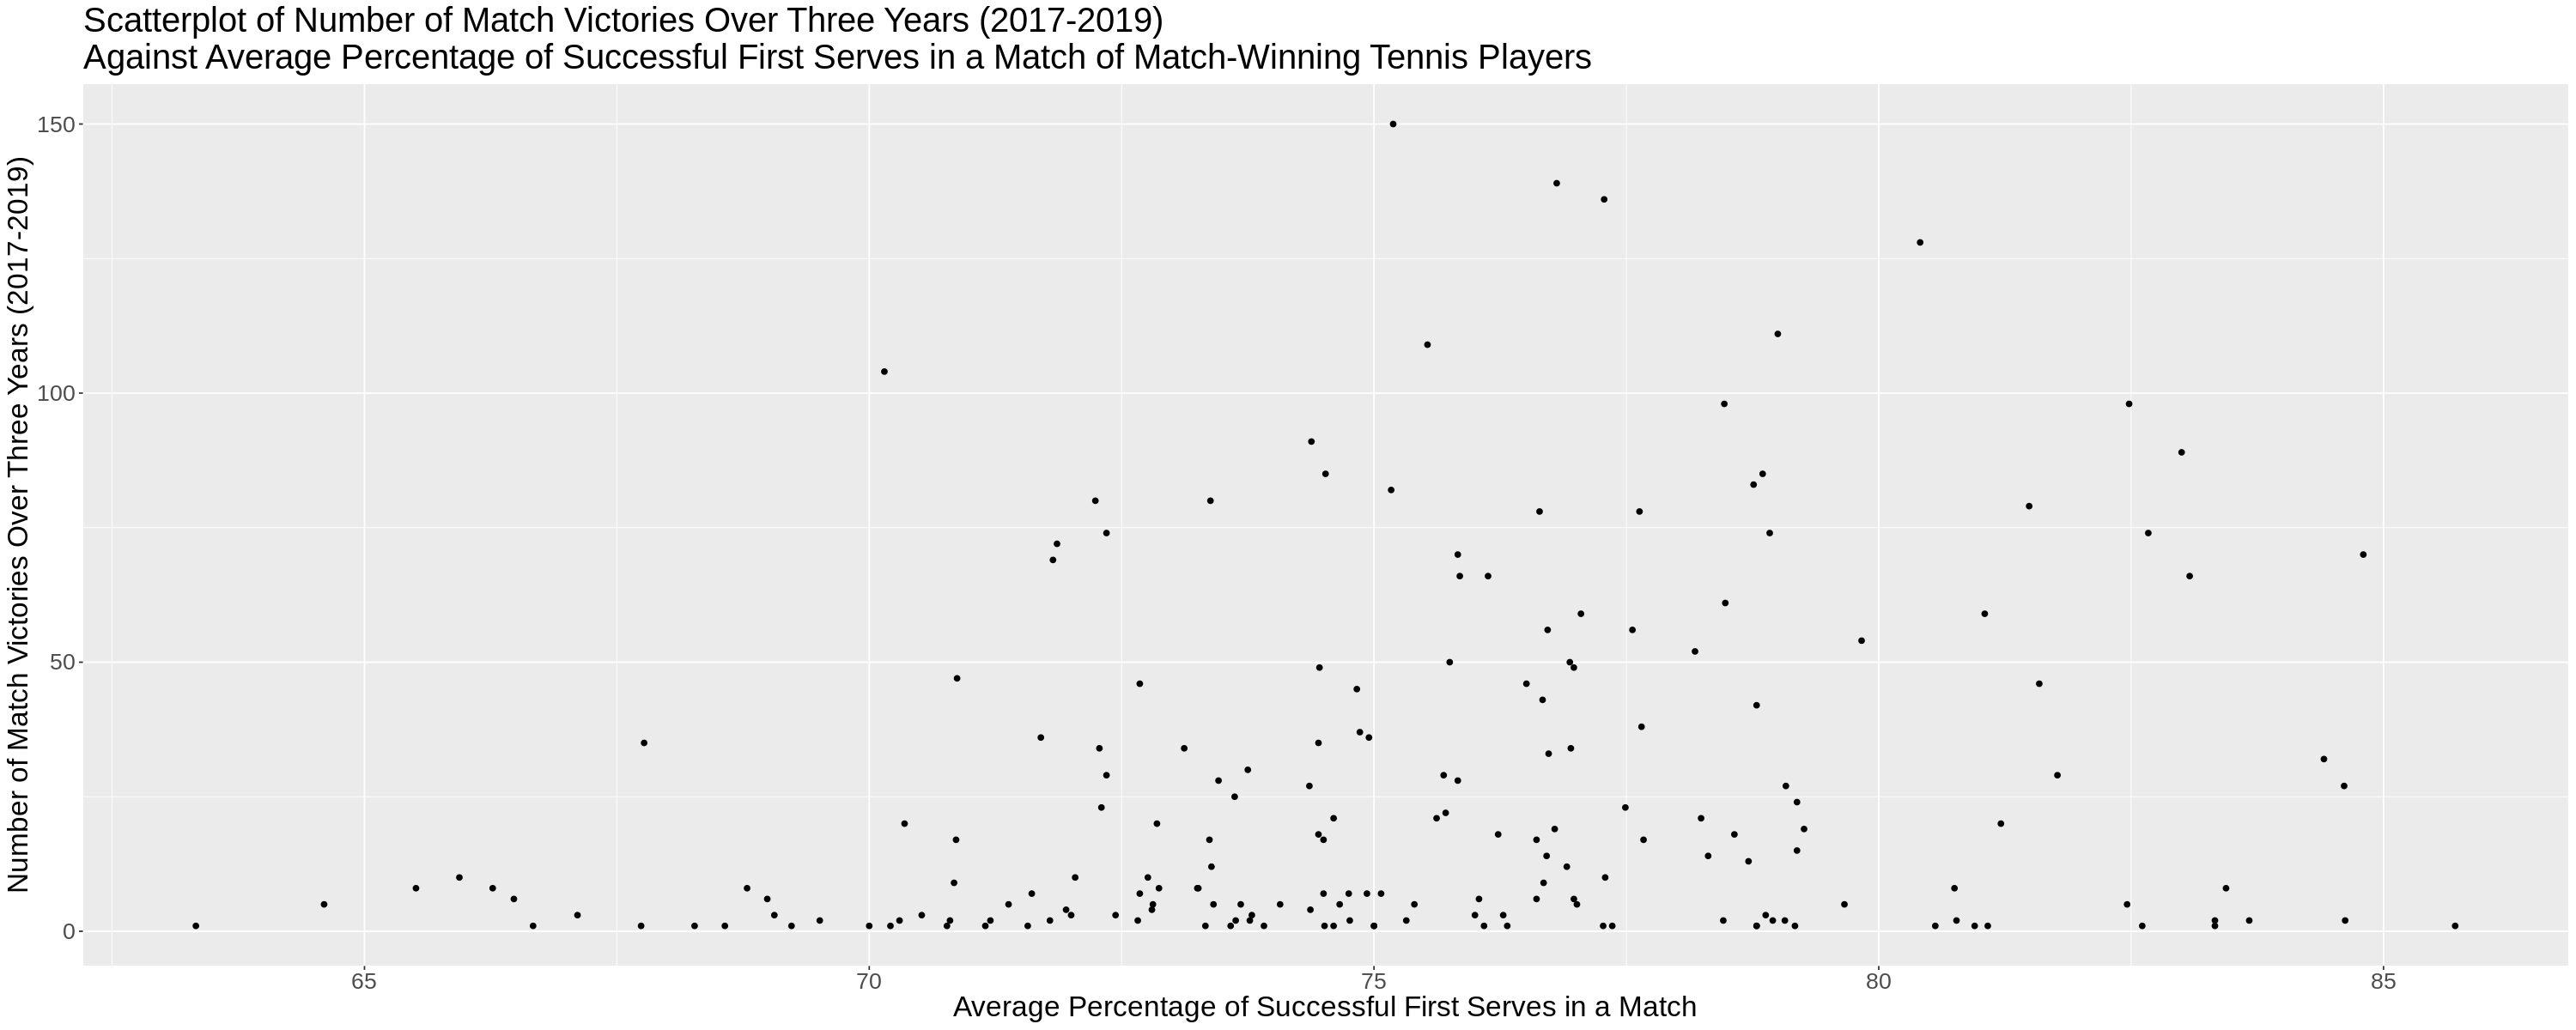

In [54]:
options(repr.plot.width = 25, repr.plot.height = 10)

first_scatterplot <- data_train%>%
    ggplot(aes(x=first_win_percentage_avg, y=number_of_wins))+
    geom_point()+
    theme (text = element_text (size = 20))+
    labs(x="Average Percentage of Successful First Serves in a Match",
         y="Number of Match Victories Over Three Years (2017-2019)")+
    ggtitle("Scatterplot of Number of Match Victories Over Three Years (2017-2019) \nAgainst Average Percentage of Successful First Serves in a Match of Match-Winning Tennis Players")
first_scatterplot

### Methods

### Expected Outcomes